# <center>Author: Victor Diallen

# Table of Contents :
* [1. Introduction](#section1)
* [2. Importing Libraries](#section2)
* [3. Loading Datasets](#section3)
* [4. Data Analysis](#section4)
* [5. Data Visualization](#section5)
* [6. Pre-Processing Text Data](#section6)
* [7. Paths to Choose](#section7)
* [8. Path 1](#section8)
* [9. Path 2](#section9)
* [10. Conclusion](#section10)

<a id="section1"></a>
# Introduction

## Problem Description

- A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

- But this is only partially happening due to the huge amount of manual work still required. Memorial Sloan Kettering Cancer Center (MSKCC) launched this competition, accepted by the NIPS 2017 Competition Track,  because we need your help to take personalized medicine to its full potential.

- Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

- Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

## File Description
- **Training_variants** - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations), Class (1-9 the class this genetic mutation has been classified on)

- **Training_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)

- **Test_variants** - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations)

- **Test_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)

<a id="section2"></a>
# Importing Libraries

In [2]:
# Python version used
from platform import python_version
print('Python Version Used in this Jupyter Notebook:', python_version())

Python Version Used in this Jupyter Notebook: 3.9.7


In [81]:
# Imports
import warnings
warnings.filterwarnings('ignore')
import os

# Data Manipulation
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from scikitplot import metrics as skplt
import plotly.express as px

# Text Processing
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from pyspark.ml.feature import Tokenizer
import gensim

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import log_loss, accuracy_score

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

In [3]:
# Libraries versions used in this jupyter notebook
%reload_ext watermark
%watermark -a "Victor Diallen Andrade do Amaral" --iversions

Author: Victor Diallen

plotly    : 5.5.0
re        : 2.2.1
pandas    : 1.3.4
scikitplot: 0.3.7
numpy     : 1.21.4
gensim    : 4.3.2
sklearn   : 1.2.1
seaborn   : 0.11.2
nltk      : 3.6.5
matplotlib: 3.4.3



<a id="section3"></a>
# Loading Datasets

In [36]:
df_train_txt = pd.read_csv('training_text.csv', sep='\|\|', engine='python', header=None, skiprows=1, names=["ID","Text"])
df_train_txt.head()

ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

In [37]:
df_train_var = pd.read_csv('training_variants.csv')
df_train_var.head()

ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

In [38]:
df_test_txt = pd.read_csv('test_text.csv', sep='\|\|', engine='python', header=None, skiprows=1, names=["ID","Text"])
df_test_txt.head()

ID                                               Text
0   0  2. This mutation resulted in a myeloproliferat...
1   1   Abstract The Large Tumor Suppressor 1 (LATS1)...
2   2  Vascular endothelial growth factor receptor (V...
3   3  Inflammatory myofibroblastic tumor (IMT) is a ...
4   4   Abstract Retinoblastoma is a pediatric retina...

In [39]:
df_test_var = pd.read_csv('test_variants.csv')
df_test_var.head()

ID     Gene Variation
0   0    ACSL4     R570S
1   1    NAGLU     P521L
2   2      PAH     L333F
3   3     ING1     A148D
4   4  TMEM216      G77A

## Merge Datasets

In [40]:
df_train = pd.merge(df_train_var, df_train_txt, how='left', on='ID')
df_train.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                Text  
0  Cyclin-dependent kinases (CDKs) regulate a var...  
1   Abstract Background  Non-small cell lung canc...  
2   Abstract Background  Non-small cell lung canc...  
3  Recent evidence has demonstrated that acquired...  
4  Oncogenic mutations in the monomeric Casitas B...

In [41]:
df_test = pd.merge(df_test_var, df_test_txt, how='left', on='ID')
df_test.head()

ID     Gene Variation                                               Text
0   0    ACSL4     R570S  2. This mutation resulted in a myeloproliferat...
1   1    NAGLU     P521L   Abstract The Large Tumor Suppressor 1 (LATS1)...
2   2      PAH     L333F  Vascular endothelial growth factor receptor (V...
3   3     ING1     A148D  Inflammatory myofibroblastic tumor (IMT) is a ...
4   4  TMEM216      G77A   Abstract Retinoblastoma is a pediatric retina...

<a id="section4"></a>
# Data Analysis

## Taking a Look at the Data

In [45]:
df_train.shape

(3321, 5)

In [46]:
df_test.shape

(5668, 4)

In [50]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
 4   Text       3316 non-null   object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [51]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5668 entries, 0 to 5667
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         5668 non-null   int64 
 1   Gene       5668 non-null   object
 2   Variation  5668 non-null   object
 3   Text       5667 non-null   object
dtypes: int64(1), object(3)
memory usage: 221.4+ KB


In [55]:
df_train.describe()

ID        Class
count  3321.000000  3321.000000
mean   1660.000000     4.365854
std     958.834449     2.309781
min       0.000000     1.000000
25%     830.000000     2.000000
50%    1660.000000     4.000000
75%    2490.000000     7.000000
max    3320.000000     9.000000

In [53]:
df_test.describe()

ID
count  5668.000000
mean   2833.500000
std    1636.354994
min       0.000000
25%    1416.750000
50%    2833.500000
75%    4250.250000
max    5667.000000

## Checking for Missing Values

In [56]:
df_train.isna().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         5
dtype: int64

In [57]:
df_test.isna().sum()

ID           0
Gene         0
Variation    0
Text         1
dtype: int64

### Handling Missing Values
- Since it's such a small number of missing values, let's drop them.

In [58]:
df_train = df_train.dropna()
df_test = df_test.dropna()

<a id="section5"></a>
# Data Visualization

### Distribution of Classes

In [68]:
df_train['Class'].value_counts()

7    952
4    686
1    566
2    452
6    273
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

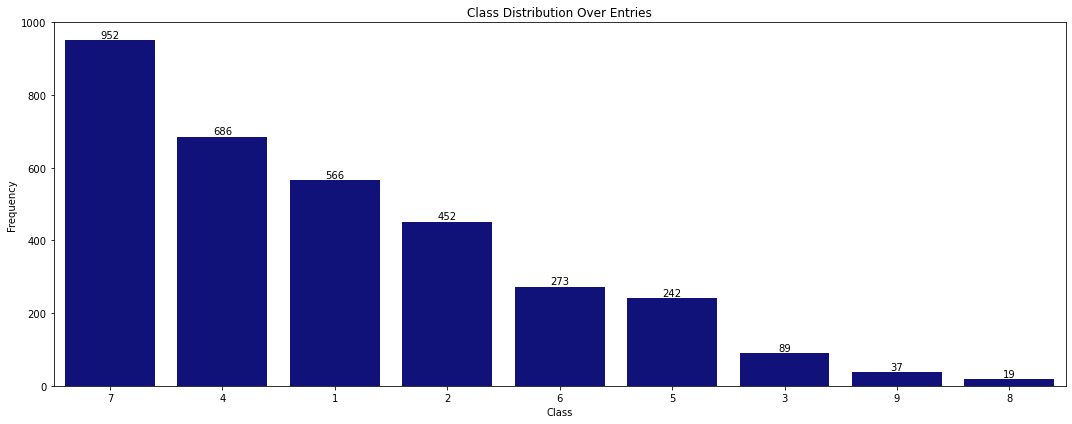

In [19]:
plt.figure(figsize=(15,6))
plt.xticks(rotation=0)
ax = sns.countplot(data=df_train, x='Class', order=df_train["Class"].value_counts().index[:20], color='DarkBlue')

ax.set_title('Class Distribution Over Entries')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')
ax.set_ylim(0,1000)
ax.bar_label(ax.containers[0]);

plt.tight_layout()
plt.show()

### Distribution of Genes

In [26]:
df_train['Gene'].value_counts()

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
RICTOR      1
PIK3R3      1
PPM1D       1
WHSC1       1
FAM58A      1
Name: Gene, Length: 262, dtype: int64

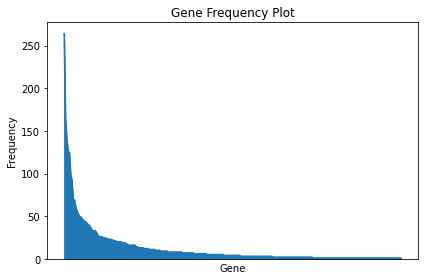

In [5]:
plt.figure()
ax = df_train['Gene'].value_counts().plot(kind='area')

ax.get_xaxis().set_ticks([])
ax.set_title('Gene Frequency Plot')
ax.set_xlabel('Gene')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

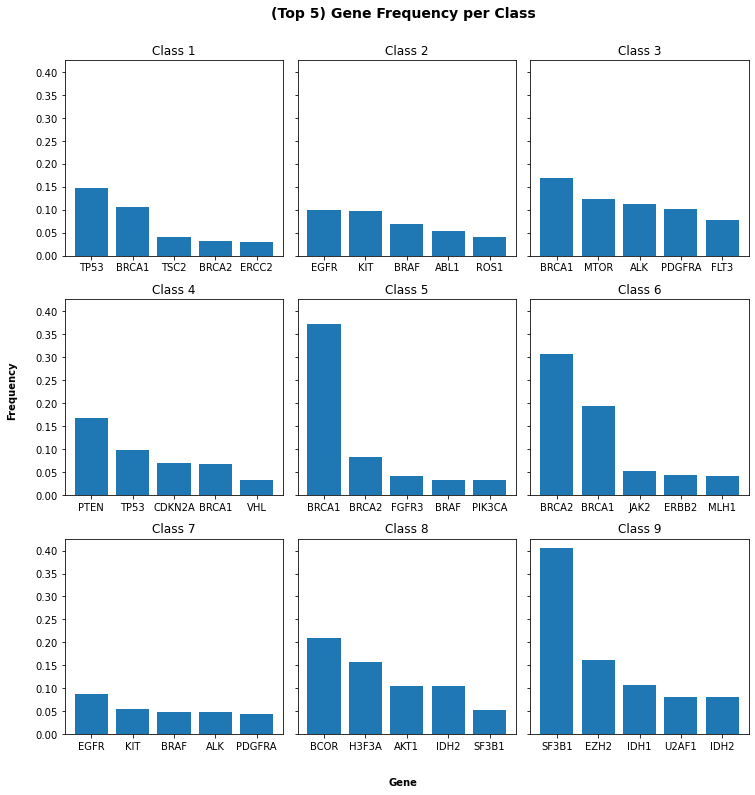

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(11,11))

# Normalize value counts for better comparison
def normalize_group(x):
    label, repetition = x.index, x
    t = sum(repetition)
    r = [n/t for n in repetition]
    return label, r

for idx, g in enumerate(df_train.groupby('Class')):
    label, val = normalize_group(g[1]["Gene"].value_counts())
    ax = axes.flat[idx]
    ax.bar(np.arange(5), val[:5],
           tick_label=label[:5]) 
    ax.set_title("Class {}".format(g[0]))
    
fig.text(0.5, 0.97, '(Top 5) Gene Frequency per Class', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0, 'Gene', ha='center', fontweight='bold')
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontweight='bold')
fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])

### Distribution of Variations

In [27]:
unique_variations = df_train['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
print(unique_variations.head(10))

Number of Unique Variations : 2993
Truncating Mutations    92
Deletion                74
Amplification           70
Fusions                 34
Overexpression           6
G12V                     4
Q61L                     3
E17K                     3
T58I                     3
Q61R                     3
Name: Variation, dtype: int64


[0.02774427 0.05006031 0.07117008 ... 0.99939686 0.99969843 1.        ]


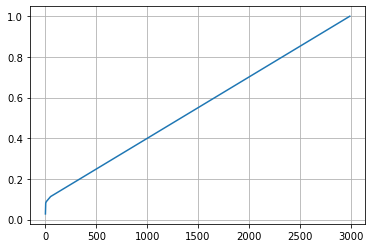

In [25]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.show()

### Word Cloud

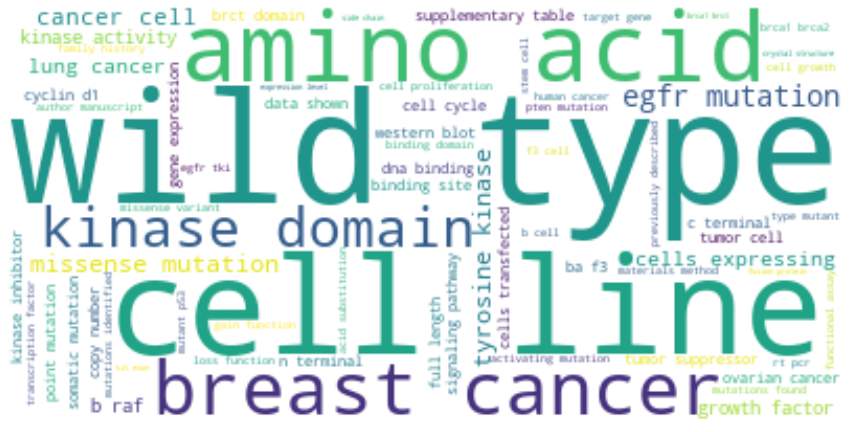

In [3]:
wordcloud_train = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(' '.join(df_train['Text']))
plt.figure(figsize=[15, 15])
plt.imshow(wordcloud_train, interpolation="bilinear")
plt.axis("off")
plt.show()

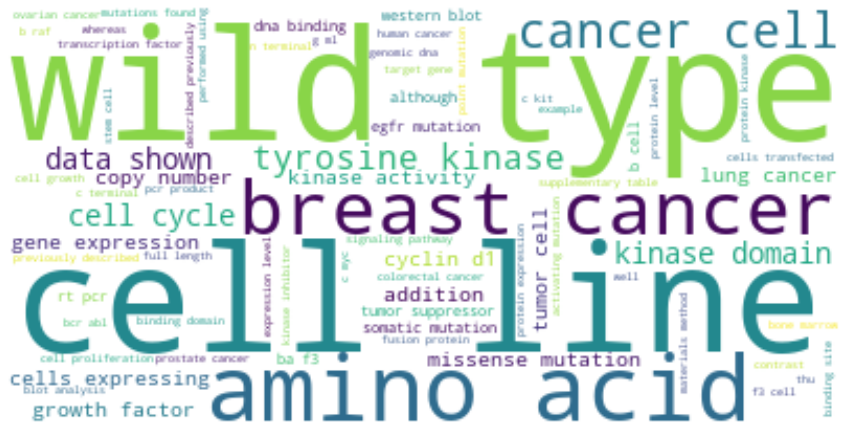

In [4]:
wordcloud_test = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(' '.join(df_test['Text']))
plt.figure(figsize=[15, 15])
plt.imshow(wordcloud_test, interpolation="bilinear")
plt.axis("off")
plt.show()

## Insights Over Data Analysis and Visualization

- The dataset is very imbalanced.
- Class 7 is the most common class.
- Class 8 is the least common class.
- The 4 most common classes (7, 4, 1 and 2) represent 80% of total data.
- BRCA1 is the most common gene.
- Variation column is mostly made of unique values.

<a id="section6"></a>
# Pre-Processing Text Data

In [28]:
custom_words = ["fig", "figure", "et", "al", "al.", '"', "’", "“", "”"]

Stopwords = set(stopwords.words('english') + custom_words)

def text_pre_process(text):
    text = str(text)
    text = text.lower() #Converting to lowercase
    #removing punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ',text)
    text = re.sub('<.*?>+',' ',text) #removing HTML Tags
    text = re.sub('[^a-zA-Z0-9\n]', ' ', text) #replacing special character with space
    text = re.sub(r'\s+', ' ',text) #removal of multiple spaces
    
    text_tokens = word_tokenize(text)
    
    #removing stopwords
    tw = [word for word in text_tokens if word not in Stopwords]
    text = (" ").join(tw)
    return text

### Applying Text Pre-Processing to Train and Test Dataframes

In [29]:
df_train['Text'] = df_train['Text'].apply(text_pre_process)

In [30]:
df_test['Text'] = df_test['Text'].apply(text_pre_process)

In [31]:
df_train.to_csv('train_dataset_preprocessed.csv', index=None)

In [32]:
df_test.to_csv('test_dataset_preprocessed.csv', index=None)

In [4]:
df_train = pd.read_csv('train_dataset_preprocessed.csv')
df_test = pd.read_csv('test_dataset_preprocessed.csv')

<a id="section7"></a>
# Paths to choose

## 1 - Drop Gene and Variation Columns

- Pros: Simpler dataset. It makes the model more generalizable.
- Cons: Lose Gene and Variation columns informations, which might be important. 

## 2 - Keep Gene and Variation Columns

- Pros: Keep Gene and Variation columns informations, and they might be important.
- Cons: Need to convert them to numerical form, probably One Hot Enconding technique being the best approach. But since they have too many unique values, it will create a great amount of columns causing a high dimensionality dataset. 

<a id="section8"></a>
# Path N° 1

## Dropping Columns

In [6]:
# Dropping Gene and Variation Columns
df_train_p1 = df_train.drop(['Gene', 'Variation'], axis=1)

## Text Vectorization

### Bag of Words

In [13]:
count_vectorizer_p1 = CountVectorizer(analyzer="word", tokenizer=nltk.word_tokenize, min_df=1, ngram_range=(1,1))    


In [14]:
bag_of_words_text_p1 = count_vectorizer.fit_transform(df_train_p1['Text'])

In [25]:
svd.explained_variance_ratio_.sum()

0.7240588648221488

In [26]:
svd_p1 = TruncatedSVD(n_components=50, n_iter=25, random_state=12)
truncated_bag_of_words_text_p1 = svd.fit_transform(bag_of_words_text_p1)

In [41]:
bow_text_p1_col_name = ["bow_p1_"+str(i) for i in range(50)]
df_bow_p1 = pd.DataFrame(truncated_bag_of_words_text_p1)
df_bow_p1.columns = bow_text_p1_col_name

In [42]:
df_bow_p1.head(5)

bow_p1_0   bow_p1_1   bow_p1_2   bow_p1_3   bow_p1_4   bow_p1_5  \
0  136.715174 -50.678814 -12.192917   0.192986   2.767516 -42.874093   
1  179.201950   1.425304   0.839945 -25.600541  10.264134  -8.610993   
2  179.201950   1.425304   0.839945 -25.600541  10.264134  -8.610993   
3  126.531063   3.307248   2.876073   7.121426   6.751696  -0.998245   
4  157.184647   4.263487  14.152487 -25.215682  12.207096  31.696441   

    bow_p1_6   bow_p1_7   bow_p1_8   bow_p1_9  ...  bow_p1_40  bow_p1_41  \
0  14.447629 -19.394658  32.277031 -16.430145  ...  -2.992862   2.066245   
1 -31.268052 -30.933451  21.758165  20.802882  ... -34.938180  53.909833   
2 -31.268052 -30.933451  21.758165  20.802882  ... -34.938180  53.909833   
3  -9.978538  16.444443   0.171154  14.835864  ... -15.188060  46.679022   
4 -46.543316  57.452329 -15.149613  14.177874  ... -29.028022  78.492764   

   bow_p1_42  bow_p1_43  bow_p1_44  bow_p1_45  bow_p1_46  bow_p1_47  \
0  -0.935887  -0.303255  -0.455312 -12.513028   3.543898  -4.600453   
1 -12.201178  60.422449  -3.199660 -31.228133   7.817299  65.288664   
2 -12.201178  60.422449  -3.199660 -31.228133   7.817299  65.288664   
3  -0.545843  36.796156  -2.568626 -20.022598  -4.879979  50.676398   
4 -14.466987  90.581087  -8.618721 -40.527389 -12.709515  70.560535   

   bow_p1_48  bow_p1_49  
0  -0.871378  -4.520297  
1 -30.241060 -46.596692  
2 -30.241060 -46.596692  
3  -7.168215 -26.867403  
4 -33.758093 -39.521119  

[5 rows x 50 columns]

### TF-IDF

In [32]:
count_vectorizer_p1_tfidf = TfidfVectorizer(analyzer="word", tokenizer=nltk.word_tokenize, max_features=250, ngram_range=(1, 2), min_df=1)    

tfidf_text_p1 = count_vectorizer_p1_tfidf.fit_transform(df_train_p1['Text'])

In [33]:
svd_p1_tfidf = TruncatedSVD(n_components=50, n_iter=25, random_state=13)
truncated_tfidf_text_p1 = svd_p1_tfidf.fit_transform(tfidf_text_p1)

In [39]:
df_tfidf_p1_col_name = ["tfidf_p1_"+str(i) for i in range(50)]
df_tfidf_p1 = pd.DataFrame(truncated_tfidf_text_p1)
df_tfidf_p1.columns = df_tfidf_p1_col_name

In [40]:
df_tfidf_p1.head(5)

tfidf_p1_0  tfidf_p1_1  tfidf_p1_2  tfidf_p1_3  tfidf_p1_4  tfidf_p1_5  \
0    0.748996   -0.073268    0.139628   -0.123295   -0.210673    0.011361   
1    0.613959   -0.107297   -0.122915   -0.075784    0.170870   -0.022659   
2    0.613959   -0.107297   -0.122915   -0.075784    0.170870   -0.022659   
3    0.693322   -0.075263   -0.096465   -0.008075   -0.024061    0.094745   
4    0.703525   -0.087273   -0.132606    0.118041    0.177725   -0.053973   

   tfidf_p1_6  tfidf_p1_7  tfidf_p1_8  tfidf_p1_9  ...  tfidf_p1_40  \
0   -0.141805   -0.109554   -0.081373    0.087857  ...    -0.016147   
1   -0.181966   -0.006093   -0.083209   -0.019578  ...     0.146894   
2   -0.181966   -0.006093   -0.083209   -0.019578  ...     0.146894   
3    0.075212    0.017298   -0.005638   -0.112539  ...     0.046699   
4   -0.017874    0.214797    0.007797   -0.230732  ...    -0.018672   

   tfidf_p1_41  tfidf_p1_42  tfidf_p1_43  tfidf_p1_44  tfidf_p1_45  \
0    -0.048122     0.068646     0.046285    -0.029975     0.030206   
1    -0.128381    -0.172925    -0.062024     0.079858     0.065807   
2    -0.128381    -0.172925    -0.062024     0.079858     0.065807   
3     0.062303    -0.007529    -0.115269    -0.053218    -0.028112   
4    -0.073459    -0.038137     0.062040    -0.050724     0.032011   

   tfidf_p1_46  tfidf_p1_47  tfidf_p1_48  tfidf_p1_49  
0    -0.083522     0.016681    -0.082468     0.020681  
1     0.071501    -0.047837    -0.023885     0.071849  
2     0.071501    -0.047837    -0.023885     0.071849  
3    -0.037102    -0.053230     0.063633     0.015550  
4     0.014035    -0.006473     0.075813     0.050862  

[5 rows x 50 columns]

## Merge Original Dataset with Vectorized Data

In [46]:
df_train_p1 = df_train_p1.join(df_tfidf_p1)
df_train_p1 = df_train_p1.join(df_bow_p1)

ValueError: columns overlap but no suffix specified: Index(['tfidf_p1_0', 'tfidf_p1_1', 'tfidf_p1_2', 'tfidf_p1_3', 'tfidf_p1_4',
       'tfidf_p1_5', 'tfidf_p1_6', 'tfidf_p1_7', 'tfidf_p1_8', 'tfidf_p1_9',
       'tfidf_p1_10', 'tfidf_p1_11', 'tfidf_p1_12', 'tfidf_p1_13',
       'tfidf_p1_14', 'tfidf_p1_15', 'tfidf_p1_16', 'tfidf_p1_17',
       'tfidf_p1_18', 'tfidf_p1_19', 'tfidf_p1_20', 'tfidf_p1_21',
       'tfidf_p1_22', 'tfidf_p1_23', 'tfidf_p1_24', 'tfidf_p1_25',
       'tfidf_p1_26', 'tfidf_p1_27', 'tfidf_p1_28', 'tfidf_p1_29',
       'tfidf_p1_30', 'tfidf_p1_31', 'tfidf_p1_32', 'tfidf_p1_33',
       'tfidf_p1_34', 'tfidf_p1_35', 'tfidf_p1_36', 'tfidf_p1_37',
       'tfidf_p1_38', 'tfidf_p1_39', 'tfidf_p1_40', 'tfidf_p1_41',
       'tfidf_p1_42', 'tfidf_p1_43', 'tfidf_p1_44', 'tfidf_p1_45',
       'tfidf_p1_46', 'tfidf_p1_47', 'tfidf_p1_48', 'tfidf_p1_49'],
      dtype='object')

In [47]:
# Drop ID column
df_train_p1.drop('ID', axis=1, inplace=True)

In [59]:
df_train_p1.head(2)

Class                                               Text  tfidf_p1_0  \
0      1  cyclin dependent kinases cdks regulate variety...    0.748996   
1      2  abstract background non small cell lung cancer...    0.613959   

   tfidf_p1_1  tfidf_p1_2  tfidf_p1_3  tfidf_p1_4  tfidf_p1_5  tfidf_p1_6  \
0   -0.073268    0.139628   -0.123295   -0.210673    0.011361   -0.141805   
1   -0.107297   -0.122915   -0.075784    0.170870   -0.022659   -0.181966   

   tfidf_p1_7  ...  bow_p1_40  bow_p1_41  bow_p1_42  bow_p1_43  bow_p1_44  \
0   -0.109554  ...  -2.992862   2.066245  -0.935887  -0.303255  -0.455312   
1   -0.006093  ... -34.938180  53.909833 -12.201178  60.422449  -3.199660   

   bow_p1_45  bow_p1_46  bow_p1_47  bow_p1_48  bow_p1_49  
0 -12.513028   3.543898  -4.600453  -0.871378  -4.520297  
1 -31.228133   7.817299  65.288664 -30.241060 -46.596692  

[2 rows x 102 columns]

## Splitting Dataset Into Train and Test

In [52]:
# Splitting df_train into new train and test dataframes
X_p1 = df_train_p1.iloc[:,2:]
y_p1 = df_train_p1['Class']

X_train_p1, X_test_p1, y_train_p1, y_test_p1 = train_test_split(X_p1, y_p1, test_size = 0.2)

## Machine Learning - Path 1

### Logistic Regression with Stochastic Gradient Descent

In [102]:
alpha = [10**x for x in range(-5,3)]
cv_log_error_array=[]
for i in alpha:
    print("for C =",i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train_p1, y_train_p1)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_p1, y_train_p1)
    sig_clf_probs = sig_clf.predict_proba(X_test_p1)
    cv_log_error_array.append(log_loss(y_test_p1, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("The log loss is:",log_loss(y_test_p1, sig_clf_probs))

for C = 1e-05
The log loss is: 1.8213221667517285
for C = 0.0001
The log loss is: 1.7235452537466351
for C = 0.001
The log loss is: 1.5284587559357528
for C = 0.01
The log loss is: 1.4875325961119275
for C = 0.1
The log loss is: 1.4441522480873281
for C = 1
The log loss is: 1.4024626318601843
for C = 10
The log loss is: 1.3591356224061844
for C = 100
The log loss is: 1.4250409069556211


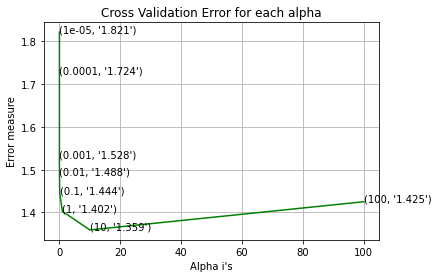

In [103]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For Best Alpha:  10


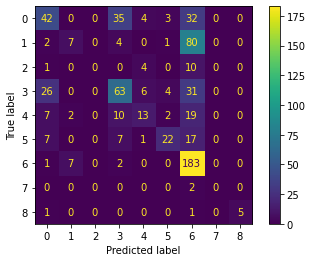

In [105]:
print('For Best Alpha: ', alpha[best_alpha])
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_p1, y_train_p1) 
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_p1, y_train_p1)
sig_clf_probs = sig_clf.predict(X_test_p1)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_p1, sig_clf_probs))
disp.plot()
plt.show()

### K - Nearest Neighbours (KNN)

In [123]:
neighbours = [5,10,15,40,50,120,150,160,170,180,200,400,500,1000]
Log_Loss_KNN = []

for neighbour in neighbours:
    model = KNeighborsClassifier(n_neighbors = neighbour)
    model.fit(X_train_p1,y_train_p1)
    prediction = model.predict_proba(X_test_p1)
    log_loss_cal = log_loss(y_test_p1,prediction,eps=1e-15)
    Log_Loss_KNN.append(log_loss_cal)
    print(f'For {neighbour} nearest neighbours the log loss is ',log_loss_cal)


For 5 nearest neighbours the log loss is  5.066183207181318
For 10 nearest neighbours the log loss is  3.4129546618831648
For 15 nearest neighbours the log loss is  3.0043483303692695
For 40 nearest neighbours the log loss is  1.8315587372058606
For 50 nearest neighbours the log loss is  1.6162225913489223
For 120 nearest neighbours the log loss is  1.5208206375203088
For 150 nearest neighbours the log loss is  1.504690681673662
For 160 nearest neighbours the log loss is  1.4695291417390732
For 170 nearest neighbours the log loss is  1.4739288929583478
For 180 nearest neighbours the log loss is  1.4853840055023226
For 200 nearest neighbours the log loss is  1.4994425809254766
For 400 nearest neighbours the log loss is  1.6007306731949789
For 500 nearest neighbours the log loss is  1.6324261917666625
For 1000 nearest neighbours the log loss is  1.7247513584313297


In [55]:
Dict = {'Nearest Neighbors':neighbours,'Log_Loss':Log_Loss}
model_df = pd.DataFrame(Dict)

model_df.sort_values(by = 'Nearest Neighbors',ascending = False,inplace = True)
fig = px.line(model_df, x="Nearest Neighbors", y="Log_Loss", title='Nearest Neighbors VS Log Loss')
fig.show()

For Best n_neighbours:  160


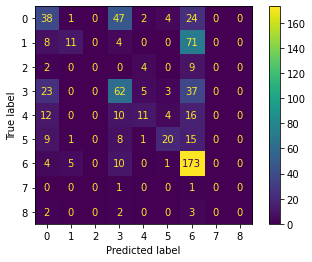

In [125]:
print('For Best n_neighbours: ', neighbours[best_neighbour])

best_neighbour = np.argmin(Log_Loss_KNN)
model = KNeighborsClassifier(n_neighbors = neighbours[best_neighbour])
model.fit(X_train_p1,y_train_p1)
prediction = model.predict(X_test_p1)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_p1,prediction))
disp.plot()
plt.show()

### Random Forest

In [111]:
N_estimators = [5,50,100,200,500,1000]
Log_Loss_RF = []
for n_estimator in N_estimators:
    model = RandomForestClassifier(n_estimators = n_estimator,max_depth = 9)
    model.fit(X_train_p1,y_train_p1)
    prediction = model.predict_proba(X_test_p1)
    log_loss_cal = log_loss(y_test_p1, prediction, eps=1e-15)
    Log_Loss_RF.append(log_loss_cal)
    print(f'For {n_estimator} n_estimator and the log loss is ',log_loss_cal)


For 5 n_estimator and the log loss is  1.186053313745007
For 50 n_estimator and the log loss is  1.1277331531092638
For 100 n_estimator and the log loss is  1.1136140356251734
For 200 n_estimator and the log loss is  1.1188417405032807
For 500 n_estimator and the log loss is  1.1183150130912338
For 1000 n_estimator and the log loss is  1.1125551275984098


In [108]:
Dict = {'N_estimators':N_estimators,'Log_Loss':Log_Loss}
model_df = pd.DataFrame(Dict)
model_df.sort_values(by = 'N_estimators',ascending = False,inplace = True)
fig = px.line(model_df, x="N_estimators", y="Log_Loss", title='N_estimators VS Log Loss')
fig.show()

For Best n_estimators :


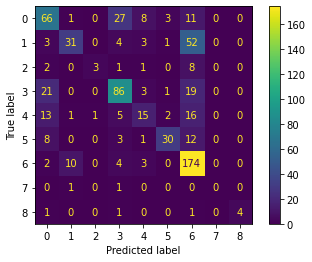

In [115]:
print('For Best n_estimators :', N_estimators[best_estimator])
best_estimator = np.argmin(Log_Loss_RF)
model = RandomForestClassifier(n_estimators = N_estimators[best_estimator], max_depth = 9)
model.fit(X_train_p1,y_train_p1)
prediction = model.predict(X_test_p1)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_p1, prediction))
disp.plot()
plt.show()

### XGBClassifier

In [179]:
# Adjusting dataset to modeling
y_train_p11 = y_train_p1-1
y_test_p11 = y_test_p1-1
X_train_p11 = X_train_p1-1
X_test_p11 = X_test_p1-1

In [184]:
Depths = [1, 4, 7, 15, 30]
Log_Loss_XGB = []
for depth in Depths:
    model = XGBClassifier(max_depth=depth,
                          objective='multi:softprob',
                          learning_rate=0.03333)
    model.fit(X_train_p11,y_train_p11)
    prediction = model.predict_proba(X_test_p11)
    log_loss_cal = log_loss(y_test_p11, prediction, eps=1e-15)
    Log_Loss_XGB.append(log_loss_cal)
    print(f'For {depth} depth and the log loss is ',log_loss_cal)


For 1 depth and the log loss is  1.5060345327110356
For 4 depth and the log loss is  1.1606439449486303
For 7 depth and the log loss is  1.0660948370287633
For 15 depth and the log loss is  1.0821002431763733
For 30 depth and the log loss is  1.0867669982557056


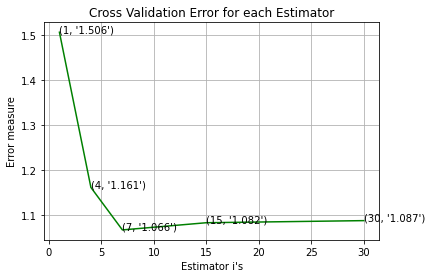

In [185]:
fig, ax = plt.subplots()
ax.plot(Depths, Log_Loss_XGB,c='g')
for i, txt in enumerate(np.round(Log_Loss_XGB,3)):
    ax.annotate((Depths[i],str(txt)), (Depths[i],Log_Loss_XGB[i]))
plt.grid()
plt.title("Cross Validation Error for each Estimator")
plt.xlabel("Estimator i's")
plt.ylabel("Error measure")
plt.show()

For Best depth: 7


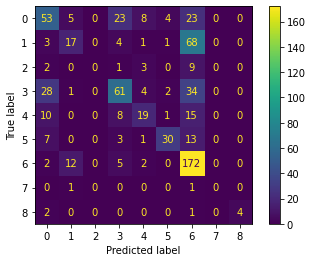

In [189]:
best_depth = np.argmin(Log_Loss_XGB)
print('For Best depth:', Depths[best_depth])
model = XGBClassifier(max_depth=best_depth,
                          objective='multi:softprob',
                          learning_rate=0.03333)
model.fit(X_train_p11,y_train_p11)
prediction = model.predict(X_test_p11)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_p11, prediction))
disp.plot()
plt.show()

<a id="section9"></a>
# Path N° 2

## Text Vectorization

- Same Bag of Word and TF-IDF objects from Path N° 1 will be used here

## Encoding Gene and Variation Columns

In [130]:
df_train_p2 = pd.get_dummies(df_train, columns=['Gene', 'Variation'], drop_first=True)

## Merge Original Dataset with Vectorized Data

In [131]:
df_train_p2 = df_train_p2.join(df_tfidf_p1)
df_train_p2 = df_train_p2.join(df_bow_p1)

In [140]:
# Drop ID column
df_train_p2.drop('ID', axis=1, inplace=True)

In [141]:
df_train_p2.shape

(3316, 3355)

## Splitting Dataset Into Train and Test

In [142]:
# Splitting df_train into new train and test dataframes
X_p2 = df_train_p2.iloc[:,2:]
y_p2 = df_train_p2['Class']

X_train_p2, X_test_p2, y_train_p2, y_test_p2 = train_test_split(X_p2, y_p2, test_size = 0.2)

## Machine Learning - Path 2

### Logistic Regression with Stochastic Gradient Descent

In [144]:
alpha = [10**x for x in range(-5,3)]
cv_log_error_array=[]
for i in alpha:
    print("for C =",i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train_p2, y_train_p2)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_p2, y_train_p2)
    sig_clf_probs = sig_clf.predict_proba(X_test_p2)
    cv_log_error_array.append(log_loss(y_test_p2, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("The log loss is:",log_loss(y_test_p2, sig_clf_probs))

for C = 1e-05
The log loss is: 1.8665108407837314
for C = 0.0001
The log loss is: 1.7190677612551268
for C = 0.001
The log loss is: 1.5272220851772458
for C = 0.01
The log loss is: 1.518174299805299
for C = 0.1
The log loss is: 1.4948186109282269
for C = 1
The log loss is: 1.4446332108952251
for C = 10
The log loss is: 1.405978694376091
for C = 100
The log loss is: 1.4720801836228334


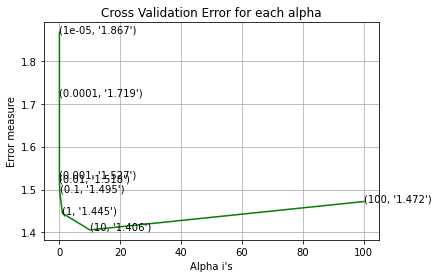

In [145]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For Best Alpha:  10


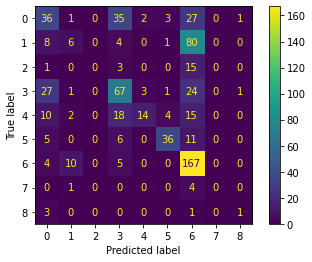

In [146]:
print('For Best Alpha: ', alpha[best_alpha])
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_p2, y_train_p2) 
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_p2, y_train_p2)
sig_clf_probs = sig_clf.predict(X_test_p2)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_p2, sig_clf_probs))
disp.plot()
plt.show()

### K - Nearest Neighbours (KNN)

In [147]:
neighbours = [5,10,15,40,50,120,150,160,170,180,200,400,500,1000]
Log_Loss_KNN = []

for neighbour in neighbours:
    model = KNeighborsClassifier(n_neighbors = neighbour)
    model.fit(X_train_p2,y_train_p2)
    prediction = model.predict_proba(X_test_p2)
    log_loss_cal = log_loss(y_test_p2,prediction,eps=1e-15)
    Log_Loss_KNN.append(log_loss_cal)
    print(f'For {neighbour} nearest neighbours the log loss is ',log_loss_cal)


For 5 nearest neighbours the log loss is  5.600992865152333
For 10 nearest neighbours the log loss is  3.6927555840444537
For 15 nearest neighbours the log loss is  2.8899714815545052
For 40 nearest neighbours the log loss is  1.871056047070481
For 50 nearest neighbours the log loss is  1.8920006919672057
For 120 nearest neighbours the log loss is  1.6499546591435483
For 150 nearest neighbours the log loss is  1.6017741453917433
For 160 nearest neighbours the log loss is  1.6103675455423891
For 170 nearest neighbours the log loss is  1.6170014158391748
For 180 nearest neighbours the log loss is  1.584411919904732
For 200 nearest neighbours the log loss is  1.5598959623943085
For 400 nearest neighbours the log loss is  1.6215073443463286
For 500 nearest neighbours the log loss is  1.660037907068037
For 1000 nearest neighbours the log loss is  1.7680491646506538


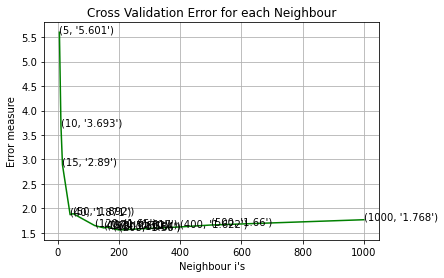

In [157]:
fig, ax = plt.subplots()
ax.plot(neighbours, Log_Loss_KNN,c='g')
for i, txt in enumerate(np.round(Log_Loss_KNN,3)):
    ax.annotate((neighbours[i],str(txt)), (neighbours[i],Log_Loss_KNN[i]))
plt.grid()
plt.title("Cross Validation Error for each Neighbour")
plt.xlabel("Neighbour i's")
plt.ylabel("Error measure")
plt.show()

For Best n_neighbours:  200


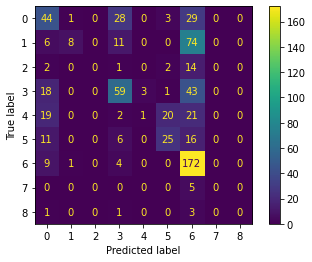

In [153]:
print('For Best n_neighbours: ', neighbours[best_neighbour])

best_neighbour = np.argmin(Log_Loss_KNN)
model = KNeighborsClassifier(n_neighbors = neighbours[best_neighbour])
model.fit(X_train_p2,y_train_p2)
prediction = model.predict(X_test_p2)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_p2,prediction))
disp.plot()
plt.show()

### Random Forest

In [155]:
N_estimators = [5,50,100,200,500,1000]
Log_Loss_RF = []
for n_estimator in N_estimators:
    model = RandomForestClassifier(n_estimators = n_estimator,max_depth = 9)
    model.fit(X_train_p2,y_train_p2)
    prediction = model.predict_proba(X_test_p2)
    log_loss_cal = log_loss(y_test_p2, prediction, eps=1e-15)
    Log_Loss_RF.append(log_loss_cal)
    print(f'For {n_estimator} n_estimator and the log loss is ',log_loss_cal)


For 5 n_estimator and the log loss is  1.3540552435717457
For 50 n_estimator and the log loss is  1.276155537114059
For 100 n_estimator and the log loss is  1.2932293163810782
For 200 n_estimator and the log loss is  1.2988142520901684
For 500 n_estimator and the log loss is  1.2906213985963728
For 1000 n_estimator and the log loss is  1.283209191363268


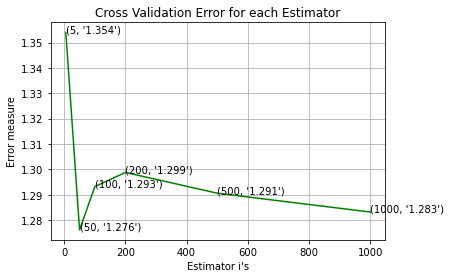

In [158]:
fig, ax = plt.subplots()
ax.plot(N_estimators, Log_Loss_RF,c='g')
for i, txt in enumerate(np.round(Log_Loss_RF,3)):
    ax.annotate((N_estimators[i],str(txt)), (N_estimators[i],Log_Loss_RF[i]))
plt.grid()
plt.title("Cross Validation Error for each Estimator")
plt.xlabel("Estimator i's")
plt.ylabel("Error measure")
plt.show()

For Best n_estimators: 50


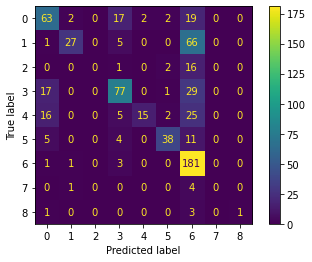

In [161]:
print('For Best n_estimators:', N_estimators[best_estimator])
best_estimator = np.argmin(Log_Loss_RF)
model = RandomForestClassifier(n_estimators = N_estimators[best_estimator], max_depth = 9)
model.fit(X_train_p2,y_train_p2)
prediction = model.predict(X_test_p2)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_p2, prediction))
disp.plot()
plt.show()

### XGBClassifier

In [190]:
# Adjusting dataset to modeling
y_train_p22 = y_train_p2-1
y_test_p22 = y_test_p2-1
X_train_p22 = X_train_p2-1
X_test_p22 = X_test_p2-1

In [191]:
Depths = [1, 4, 7, 15, 30]
Log_Loss_XGB = []
for depth in Depths:
    model = XGBClassifier(max_depth=depth,
                          objective='multi:softprob',
                          learning_rate=0.03333)
    model.fit(X_train_p22,y_train_p22)
    prediction = model.predict_proba(X_test_p22)
    log_loss_cal = log_loss(y_test_p22, prediction, eps=1e-15)
    Log_Loss_XGB.append(log_loss_cal)
    print(f'For {depth} depth and the log loss is ',log_loss_cal)


For 1 depth and the log loss is  1.4543758635969155
For 4 depth and the log loss is  1.1313740405068824
For 7 depth and the log loss is  1.0014210266187986
For 15 depth and the log loss is  1.0203312791573833
For 30 depth and the log loss is  1.0214318539665301


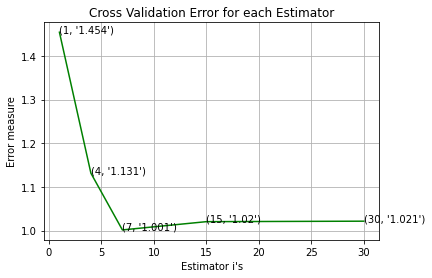

In [192]:
fig, ax = plt.subplots()
ax.plot(Depths, Log_Loss_XGB,c='g')
for i, txt in enumerate(np.round(Log_Loss_XGB,3)):
    ax.annotate((Depths[i],str(txt)), (Depths[i],Log_Loss_XGB[i]))
plt.grid()
plt.title("Cross Validation Error for each Estimator")
plt.xlabel("Estimator i's")
plt.ylabel("Error measure")
plt.show()

For Best depth: 7


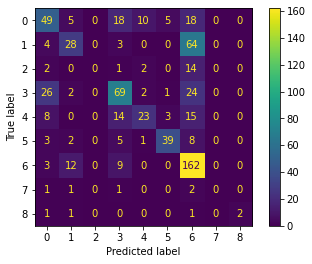

In [193]:
best_depth = np.argmin(Log_Loss_XGB)
print('For Best depth:', Depths[best_depth])
model = XGBClassifier(max_depth=best_depth,
                          objective='multi:softprob',
                          learning_rate=0.03333)
model.fit(X_train_p22,y_train_p22)
prediction = model.predict(X_test_p22)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_p22, prediction))
disp.plot()
plt.show()

<a id="section10"></a>
# Conclusion

- Path 1 worked better for all algorithms except XGBClassifier
- XGBClassifier returned the best results
- One of the reasons XGBCLassifier worked better in path 2 is because it's an algorith that “beats” the curse of dimensionality by not relying on any distance metric. Also the similarity between data points are learnt from the data through adaptive adjustment of neighbourhoods. This makes the model immune to the curse of dimensionality.
- The best log loss obtained was 1.0014210266187986
- Better results could be obtained changing the hyperparameters